- 学修番号: 21445095
- 氏名: 小田龍司

# 課題 2.1　決定木分析

- 2.1.1 AUCが最大になる max_depth
- 2.1.2 決定木の描画
- 2.1.3 散布図の描画

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.tree import plot_tree

autos = pd.read_csv('data/imports-85.data', na_values='?')
autos.columns = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
                    'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
                    'wheel_base', 'length','width', 'height', 'curb_weight',
                    'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system',
                    'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm',
                    'city_mpg', 'highway_mpg','price']
# 表示する最大列数の設定
pd.set_option('display.max_columns', len(autos.columns))

### 2.1 で用いるDataFrame

autos から symboling, normalized_losses, city_mpg, highway_mpg 列を除外したうえで、highway_mpgから中央値よりも大きければ1、小さいか等しければ0を値としたhighway_mpg_01列を追加した pandas DataFrame を作成の後、欠損値 NaN がある行を除去。

In [2]:
df = autos.drop(['symboling', 'normalized_losses', 'city_mpg', 'highway_mpg'], axis=1)
# ダミー変数化
highway_mpg_median = autos.highway_mpg.median()
df['highway_mpg_01'] = \
    autos['highway_mpg'].map(lambda x: 1 if x > highway_mpg_median else 0)
df = pd.get_dummies(data=df, drop_first=True)
# 欠損値 NaN がある行の除去
df = df.dropna()
# 確認
print(df.groupby('highway_mpg_01').size())
df.head(1)

highway_mpg_01
0    100
1     94
dtype: int64


,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,price,highway_mpg_01,...,num_of_cylinders_five,num_of_cylinders_four,num_of_cylinders_six,num_of_cylinders_three,num_of_cylinders_twelve,num_of_cylinders_two,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,16500.0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0


<hr>

highway_mpg_01 を目的変数、それ以外を説明変数とし、決定木を用いて以下に答えなさい。
- 分割の規準は、エントロピー (criterion='entropy') を用いること。

### 2.1.1 AUCが最大になる max_depth

交差検証により、AUCが最大になる max_depth を求めなさい。
- 分割数は 10 とする。

In [3]:
# 説明変数、目的変数を作成
y = 'highway_mpg_01'
X = df.drop([y], axis=1)
Y = df[y]

# 決定木の深さを引き数にとり交差検証法によるAUCを表示する関数
def classify(depth):
    # 決定木を作成
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)

    # 交差検証の実行
    score = cross_val_score(model, X, Y, cv=5, scoring='roc_auc')
    print('depth={:2}: AUC={:.3f} (+/- {:.3f})'.format(depth, score.mean(), score.std()))

# 深さ1～10までの決定木を作りそれぞれのAUCを表示する
for d in range(1, 11, 1):
    classify(d)

depth= 1: AUC=0.925 (+/- 0.063)
depth= 2: AUC=0.955 (+/- 0.015)
depth= 3: AUC=0.949 (+/- 0.028)
depth= 4: AUC=0.938 (+/- 0.032)
depth= 5: AUC=0.940 (+/- 0.030)
depth= 6: AUC=0.915 (+/- 0.053)
depth= 7: AUC=0.905 (+/- 0.063)
depth= 8: AUC=0.910 (+/- 0.061)
depth= 9: AUC=0.916 (+/- 0.052)
depth=10: AUC=0.916 (+/- 0.052)


classify(depth)の実行結果より、AUCが一番大きくなるdepthは2。
よって`max_depth = 2`

<hr>

### 2.1.2 決定木の描画

2.1.1で求めた max_depth の決定木を描画しなさい。
- class_names は適切に付けること。

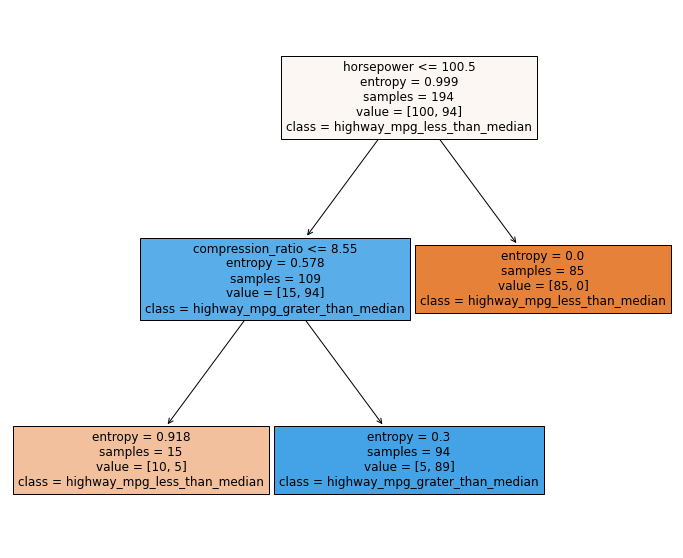

In [4]:
# 決定木の描画
plt.figure(figsize=(12, 10))
model = DecisionTreeClassifier(criterion='entropy', max_depth=2)
model.fit(X, Y)
plot_tree(model, feature_names=X.columns, class_names=['highway_mpg_less_than_median', 'highway_mpg_grater_than_median'], filled=True)
plt.show()

<hr>

### 2.1.3 散布図の描画

2.1.2で作成した決定木における正規化された情報利得の総和の上位2つとなる説明変数の散布図を描画しなさい。
- highway_mpg_01の値で色分けすること。
- 2.1.2の説明変数のうち大きい方をX軸とすること。
- 2.1.2で作成した決定木の情報から領域を分割する直線を重ねてひくこと。

In [5]:
# 情報利得の総和を書く説明変数ごとにデータフレームで降順表示
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['gain']).\
    sort_values('gain', ascending=False)

,gain
horsepower,0.861487
compression_ratio,0.138513
engine_type_ohc,0.000000
engine_type_l,0.000000
engine_type_dohcv,0.000000
...,...
make_porsche,0.000000
make_renault,0.000000
make_saab,0.000000
make_subaru,0.000000


情報利得の総和データフレームの降順を見ると、horsepower, compression_ratioが上位2つの説明変数と判断できる。

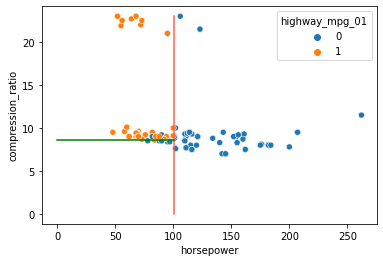

In [6]:
# 散布図の描画
sns.scatterplot(x=df.horsepower, y=df.compression_ratio, hue=df.highway_mpg_01)
# 分割線：　horsepower <= 100.5
plt.plot([100.5, 100.5], [0, df.compression_ratio.max()], color='tomato')
# 分割線：　compression_ratio <= 8.55
plt.plot([0, 100.5], [8.55, 8.55], color='green')